# ECE133A Winter 2023 Final Project
## Aaron Isara 905563052, Sudarshan Seshadri 105490936
### March 3, 2023

This notebook is the best way to view the project report. The report is also available as a LaTeX file in the repository.

# 1. Introduction
This section 1 is due February 21, 2023 at 11:59pm.

## 1.1. Dataset Description

We are using the [US Accidents (2016 - 2021) dataset compiled by Sobhan Moosavi and colleagues](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents), which contains a set of 2.9 million traffic accident entries occurring in the United States between 2016 and 2021 described by a set of 43 features.\
\
We intend to clean the dataset to remove features that cannot be translated directly to numerical values or which very likely would not have an impact on the predictive capabilities of the model. Below is a description of the features we intend to use, which have been selected and/or derived from the original 43:




1.  Numeric

    1.  *Distance* (mi): Distance over which accident occurred

    2.  *Humidity* (%): Humidity during the accident

    3.  *Pressure* (in): Barometric pressure during the accident

    4.  *Severity*: Categorical rating of severity of accident from 1 to
        4 based on effect on level of traffic disruption, with 1 being
        the least disruption.

    5.  *Start Latitude*: Latitude of start of accident

    6.  *Start Longitude*: Longitude of start of accident

    7.  *Start Time* (s): The time of the accident represent as a Unix
        timestamp

    8.  *Temperature* ($^{\circ}$F): Local temperature during the
        accident

    9.  *Visibility* (mi): Visibility during the accident

2.  Binary

    1.  *Amenity*: Was there an amenity nearby the accident?

    2.  *Astronomical Twilight*: Did the accident occur during the night
        with respect to astronomical twilight?

    3.  *Bump*: Was there a speed bump nearby the accident?

    4.  *Civil Twilight*: Did the accident occur during the night with
        respect to civil twilight?

    5.  *Crossing*: Was there a traffic crossing nearby the accident?

    6.  *Give way*: Was there a give way traffic sign nearby the
        accident?

    7.  *No exit*: Was there a no exit sign nearby the accident?

    8.  *Railway*: Was there a railway nearby the accident?

    9.  *Roundabout*: Was there a roundabout nearby the accident?

    10. *Side*: Did the accident occur on the left side of the street?

    11. *State* (one-hot encoded): Which state the accident occurred in

    12. *Station*: Was there a station nearby the accident?

    13. *Stop*: Was there a stop sign nearby the accident?

    14. *Sunrise/Sunset*: Did the accident occur during the night with
        respect to sunrise/sunset?

    15. *Traffic Calming*: Was there a traffic calming structure nearby
        the accident?

    16. *Traffic Signal*: Was there a traffic signal nearby the
        accident?

    17. *Weather Condition* (one-hot encoded): What was the category of
        weather conditions during the accident

3.  Derived

    1.  *Amount of Light*: Derived from *Start Time*; A heuristic for
        the level of light present during the accident, based on the
        hour of the day

    2.  *Day Number*: Derived from Start Time; The day in the year the
        accident occurred (with 0 representing January 1st and 364
        representing December 31st)

    3.  *Hour* (one-hot encoded): Derived from *Start Time*; What hour
        the accident occurred in during the day

    4.  *Seconds Since Start of Day:* (s): Derived from *Start Time*; Number of
        seconds since 12:00 AM on the day of the accident

    5.  *Wind Vector X-component* (mi/hr): Derived from *Wind Direction*
        and *Wind Speed*; The x-component of the wind's vector at the
        time of the accident

    6.  *Wind Vector Y-component* (mi/hr): Derived from *Wind Direction*
        and *Wind Speed*; The y-component of the wind's vector at the
        time of the accident

## 1.2. Problem Description

We will perform a classification on the data to predict the severity of
an accident given the remaining input features.


## 1.3. Project Plan

We intend to begin by simply performing binary classification on the
data, classifying between a severity of 1 to 2 and a severity of 3 to 4.
If the model's test accuracy is not high enough (less than 80%
accuracy), then we may try introducing more features derived from the
originals. After settling on a good feature set, we will then attempt
multi classification by training 4 one-versus-all binary classifiers,
one for each severity category, and predicting severity by selecting the
category whose classifier scored the highest in its favor. We may also
experiment with one-versus-one binary classifiers if time permits.

# 2. Datastructure

This section 2 is due February 28, 2023 at 11:59pm.


We begin by importing the necessary libraries and loading the dataset. Note that for now, we will be using a subset of the data, containing only the first 10,000 entries, to speed up the development process. We will later switch to the full dataset once we have a fully working model.

In [184]:
import numpy as np
import pandas as pd
import pickle
import sklearn.cluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# csv_file_name = "final_data_crashes.csv"
csv_file_name = "final_data_crashes_small_even.csv"
df = pd.read_csv(csv_file_name)


# csv_file_name = "final_data_crashes_small_original.csv"
# df_original = pd.read_csv(csv_file_name)


# create a new df that is just df but with only 10,000 random rows. Save it to a new csv file. Uncomment to run (takes a while, but only needs to be run once as long as the csv file is saved)
# df_small = df.sample(n=10000)
# df_small.to_csv("final_data_crashes_small.csv")
# df = df_small

We will store sereral representations of the data to use with different libraries.

In [185]:
cols = []
for col in df.items():
    cols.append(col[1].tolist())
data = list(zip(*cols))

datanp = np.array(data)
datapd = pd.DataFrame(datanp)
pd.options.display.max_columns = datanp.shape[1]

# store the column names
col_names = []
for j in range(len(df.columns)):
    column_name = df.columns[j]
    # print('    Column', column_name)
    col_names.append(column_name)

In [186]:
print(col_names)

['Severity', 'StartTime', 'Day Number', 'Seconds Since Start Of Day', 'Duration', 'Start Latitude', 'Start Longitude', 'Distance(mi)', 'Side is R', 'Temperature(F)', 'Wind Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind Speed(mph)', 'Precipitation(in)', 'Wind x', 'Wind y', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Clear', 'Cloudy', 'Cloudy / Windy', 'Drizzle', 'Fair', 'Fair / Windy', 'Fog', 'Fog / Windy', 'Haze', 'Haze / Windy', 'Heavy Rain', 'Heavy Rain / Windy', 'Heavy Snow', 'Heavy T-Storm', 'Heavy T-Storm / Windy', 'Heavy Thunderstorms and Rain', 'Light Drizzle', 'Light Freezing Drizzle', 'Light Freezing Fog', 'Light Freezing Rain', 'Light Rain', 'Light Rain / Windy', 'Light Rain with Thunder', 'Light Snow', 'Light Snow / Windy', 'Light Thunderstorms and Rain', 'M

## 2.1 Standardization

Below is a matrix containing relevant statistics for each of the feature
columns. This is before we standardize our features. Notice that the mean and standard deviation are very different for each feature, which is why we will standardize our features.

In [187]:
display(datapd.describe(include = 'all'))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165
count,10000.00000,1.000000e+04,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.00000,10000.0000,10000.00000,10000.0000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.0000,10000.00000,10000.0,10000.00000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.00000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.50000,1.570437e+09,175.389100,47863.13460,2.161978e+04,36.720895,-95.203520,0.756714,0.82950,63.088290,61.945440,61.838600,29.398276,9.276431,7.810260,0.005100,-1.311963,-0.533338,0.011400,0.0001,0.132600,0.003900,0.125100,0.003700,0.009400,0.0,0.023800,0.016900,0.000600,0.197400,0.0,0.682300,0.719300,0.764300,0.797600,0.111700,0.111800,0.003000,0.000600,0.320600,0.004700,0.010100,0.0,0.00840,0.0001,0.00380,0.0001,0.000500,0.001000,0.0,0.000200,0.002700,0.000200,0.000200,0.000500,0.048700,0.00110,0.001700,0.014800,0.000600,0.000500,0.000400,0.145300,0.002700,0.000200,0.060000,0.092700,0.002800,0.0001,0.009300,0.000400,0.02770,0.000200,0.000300,0.00180,0.002400,0.0001,0.00160,0.0,0.00160,0.001300,0.00070,0.000200,0.000600,0.004600,0.004000,0.071800,0.170300,0.029700,0.012300,0.004300,0.002200,0.11010,0.029300,0.00440,0.001700,0.04270,0.012200,0.003000,0.002600,0.017800,0.00440,0.027100,0.000500,0.021500,0.016400,0.011500,0.001300,0.002200,0.037000,0.000400,0.00180,0.001000,0.021200,0.002200,0.001700,0.039000,0.021600,0.003100,0.036200,0.031500,0.002300,0.015000,0.000200,0.027100,0.063000,0.012400,0.043300,0.0001,0.020100,0.009100,0.002400,0.000400,12.789900,0.02250,0.019600,0.015800,0.015800,0.019700,0.029000,0.040600,0.050000,0.049900,0.043200,0.040600,0.040900,0.045300,0.050700,0.058200,0.072200,0.084100,0

Now we standardize the features so that the mean and standard deviation are 0 and 1, respectively.
One-hot encoded features were not ignored, but are not
particularly insightful.

In [188]:
from sklearn.preprocessing import StandardScaler


first_col = datanp[:, 0]
rest_cols = datanp[:, 1:]

# normalize the remaining columns
scaler = StandardScaler()
rest_cols_normalized = scaler.fit_transform(rest_cols)

# concatenate the first column back to the normalized array
datanp_normalized = np.hstack((first_col.reshape(-1, 1), rest_cols_normalized))


datapd_normalized = pd.DataFrame(datanp_normalized)
display(datapd_normalized.describe(include = 'all'))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,2.50000,2.430234e-15,-1.328715e-16,1.158185e-16,5.684342e-18,-1.194902e-14,2.587086e-14,-3.495870e-16,-1.250555e-16,-7.759127e-16,-4.934719e-15,2.273737e-17,-2.548362e-14,-2.282619e-16,-8.924417e-16,-1.143974e-16,-3.035794e-16,-1.101341e-17,-1.207923e-17,-6.394885e-18,-2.806644e-17,-1.350031e-17,3.730349e-17,2.629008e-17,5.364598e-17,0.0,-5.009326e-17,-1.421085e-18,1.776357e-18,-2.842171e-18,0.0,6.750156e-18,-1.072920e-16,-1.385558e-17,9.094947e-17,-2.486900e-17,-2.131628e-17,-3.375078e-17,8.881784e-18,-3.623768e-17,7.105427e-19,-1.207923e-17,0.0,1.829648e-17,-3.907985e-18,2.149392e-17,7.105427e-19,-7.460699e-18,-1.421085e-18,0.0,-8.526513e-18,1.136868e-17,-8.526513e-18,-1.421085e-18,-3.552714e-18,1.847411e-17,1.136868e-17,-9.237056e-18,-2.842171e-17,1.421085e-17,-1.207923e-17,4.618528e-18,-3.552714e-18,2.842171e-17,-2.131628e-18,5.861978e-17,-5.044853e-17,6.572520e-18,-4.973799e-18,-3.019807e-18,4.618528e-18,5.186962e-17,-3.552714e-18,6.039613e-18,-2.557954e-17,-3.410605e-17,-4.263256e-18,-5.861978e-18,0.0,-1.705303e-17,-2.842171e-18,-7.105427e-19,-2.486900e-18,2.131628e-18,-1.847411e-17,9.947598e-18,-4.689582e-17,-6.288303e-17,-5.329071e-18,-3.836931e-17,-3.552714e-18,-2.842171e-17,-1.474376e-17,1.847411e-17,2.771117e-17,5.684342e-18,-4.813927e-17,-3.197442e-17,2.877698e-17,1.385

## 2.2 $k$-means Clustering
To determine the best $k$, we performed k-means clustering for
$k = 1 \dots 9$ and plotted the inertia of the model for each $k$. Using
the elbow heuristic, we determined that the best $k$ is $k = 3$, as it
is the point after which the inertia seems to decrease linearly. Below
is the relevant plot:\

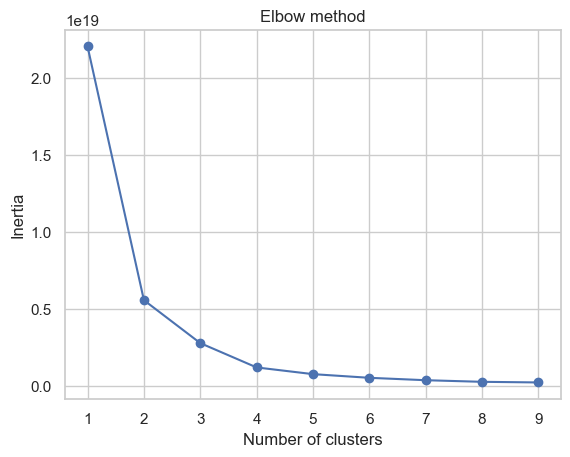

In [189]:
# Borrowed from https://www.w3schools.com/python/python_ml_k-means.asp#:~:text=K%2Dmeans%20is%20an%20unsupervised,the%20variance%20in%20each%20cluster.

num_clusters_tried = 10
inertias = []
for i in range(1, num_clusters_tried):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(datanp)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,num_clusters_tried), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## 2.3. SVD

Below is the SVD decomposition for our input data:\
\
The $U$ matrix represents the \"eigen\" data points for the input data,
representing an orthonormal basis for the data. The most significant
basis vector by definition of SVD decomposition is the first column of
the $U$ vector:


In [190]:
arr = np.array(data)
arrT = arr.transpose()

U, D, V = np.linalg.svd(arrT)

display(U)



array([[-0.        ,  0.00000009, -0.00000177, ...,  0.        ,
        -0.        , -0.        ],
       [-1.        , -0.00001354, -0.00003047, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00000011,  0.00000274, -0.00006824, ..., -0.        ,
        -0.        ,  0.        ],
       ...,
       [-0.        , -0.00000001,  0.0000001 , ...,  0.0223119 ,
        -0.00018221, -0.02270881],
       [-0.        , -0.        ,  0.0000008 , ...,  0.0223119 ,
        -0.00018221, -0.02270881],
       [-0.        ,  0.00000001, -0.00000035, ...,  0.0223119 ,
        -0.00018221, -0.02270881]])

In this vector, each element represents the general weighting assigned
to each feature. Thus, the vector will contain $N$ elements, where $N$
is the number of features. We will define the \"most significant\"
features as the features with the highest weights in this vector. Based
on this definition, below are the 10 most significant features and their
relative weights:

In [191]:
threshold = 0.01
top_eigenpoint = U[:1][0] # The highest weighted "eigen" data point

print(U.shape)

print("Most Significant Features (weight > {0}):\n".format(threshold))
print("Feature\t\t\t\tWeight")
print("------------------------------------------------")

most_sig_features = []
for i in range(top_eigenpoint.size):
    if(top_eigenpoint[i] > threshold):
        most_sig_features.append((i, df.columns[i], top_eigenpoint[i]))

most_sig_features.sort(key=lambda x:x[2],reverse=True)
for feature in most_sig_features:
    print("{0}. {1:<20}\t{2}".format(feature[0], feature[1], feature[2]))

(166, 166)
Most Significant Features (weight > 0.01):

Feature				Weight
------------------------------------------------
13. Visibility(mi)      	0.11089507942026473
18. Amenity             	0.10824315279421487
10. Wind Chill(F)       	0.06536275002244232
29. Traffic_Signal      	0.04866209868071053
40. Fair / Windy        	0.023147461393806686
56. Light Rain / Windy  	0.022050804637666066
17. Wind y              	0.016978774442293516
31. Sunrise_Sunset      	0.016933448629315787
28. Traffic_Calming     	0.015851751030908547
41. Fog                 	0.015458433608572911
32. Civil_Twilight      	0.014097480471764812
54. Light Freezing Rain 	0.013961847976038623
67. Partly Cloudy / Windy	0.01285634349744494
15. Precipitation(in)   	0.012241814858789031
43. Haze                	0.010423132818704647
33. Nautical_Twilight   	0.010176033902566798


## 2.4. Correlation Matrix

### 2.4.1. Correlation Matrix Graph

Below is the correlation matrix for our input data. We can visualize the matrix in a graph, where the yellow squares indicate a high positive correlation value and dark blue represents a high negative correlation value. We can see that the matrix is very sparse, with most of the values being 0. This is because the data is very high dimensional, and most of the features are not correlated with each other.

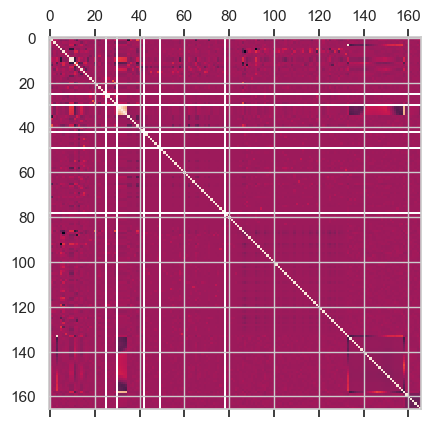

In [192]:
# corr = np.corrcoef(datanp, rowvar=False) # this is the numpy version
corr = datapd.corr()
plt.matshow(corr)
plt.show()

### 2.4.2. Most correlated features

Now we can print out which features are the most correlated to each other:

In [193]:
# print which columns are most correlated
features_and_correlations = []

for i in range(corr.shape[0]):
    for j in range(i,corr.shape[1]):
        if abs(corr.iloc[i,j]) > 0.75 and i != j:
            features_and_correlations.append((col_names[i], col_names[j], corr.iloc[i,j]))

# sort by absolute value of correlation
features_and_correlations.sort(key=lambda tup: abs(tup[2]), reverse=True)

for feature in features_and_correlations:
    print("Column", feature[0], "is correlated with Column " + feature[1] + " with correlation coefficient ", feature[2])



Column Seconds Since Start Of Day is correlated with Column Hour with correlation coefficient  0.9987549659106492
Column Temperature(F) is correlated with Column Wind Chill(F) with correlation coefficient  0.9941045701078459
Column Sunrise_Sunset is correlated with Column Civil_Twilight with correlation coefficient  0.9149943979996519
Column Nautical_Twilight is correlated with Column Astronomical_Twilight with correlation coefficient  0.9000834191051156
Column Civil_Twilight is correlated with Column Nautical_Twilight with correlation coefficient  0.8889589060958937
Column Sunrise_Sunset is correlated with Column Nautical_Twilight with correlation coefficient  0.8138173410698215
Column Civil_Twilight is correlated with Column Astronomical_Twilight with correlation coefficient  0.800299723280984
Column Sunrise_Sunset is correlated with Column Amount of Light with correlation coefficient  0.7809848251546527
Column Civil_Twilight is correlated with Column Amount of Light with correlation

There are some very obvious correlations: of course the time of day in seconds and the time of day in hours would be highly correlated. Additionally, different ways of measuring whether it is twillight or not agree with each other greatly. 

We can also see that the amount of light is highly correlated with the time of day, which makes sense. The correlation between the state and the longitude is also very high, which makes sense because the longitude is a function of the state. The correlation between the bump and traffic calming is also very high, which makes sense because they are both traffic calming structures.

### 2.4.3. Most correlated features with severity
For more helpful insights, let us see which features are the most correlated with the severity of the accident:

In [194]:
def print_highest_correlations(range11, range12, range21, range22, threshold):
    features_and_correlations = []

    for i in range(range11, range12):
        for j in range(range21, range22):
            if abs(corr.iloc[i,j]) > threshold and i != j:
                features_and_correlations.append((col_names[i], col_names[j], corr.iloc[i,j]))

    # sort by absolute value of correlation
    features_and_correlations.sort(key=lambda tup: abs(tup[2]), reverse=True)

    for feature in features_and_correlations:
        print("Column", feature[0], "is correlated with Column " + feature[1] + " with correlation coefficient ", feature[2])
        
# print which columns are most correlated to severity
print_highest_correlations(0,1 , 0, corr.shape[1], 0.1)


Column Severity is correlated with Column StartTime with correlation coefficient  -0.40687445386508286
Column Severity is correlated with Column Traffic_Signal with correlation coefficient  -0.29639210911016445
Column Severity is correlated with Column Crossing with correlation coefficient  -0.27164439428317516
Column Severity is correlated with Column Clear with correlation coefficient  0.2684726867648837
Column Severity is correlated with Column AZ with correlation coefficient  -0.26816552822804135
Column Severity is correlated with Column Start Longitude with correlation coefficient  0.2662234631049822
Column Severity is correlated with Column Fair with correlation coefficient  -0.24051611990842828
Column Severity is correlated with Column Wind Chill(F) with correlation coefficient  -0.23273981030237745
Column Severity is correlated with Column Humidity(%) with correlation coefficient  0.2316269032195222
Column Severity is correlated with Column Temperature(F) with correlation coeff

From the above results, it looks like the severity of the accident is most correlated with the time of day, some of the weather conditions, and to an extent some of the states the accident was in. This makes sense, as accidents are more likely to occur at certain times of day, when the weather is bad, and in states with certain road conditions or traffic laws.



### 2.4.4. Most correlated states with severity
Now let us look at which states are most correlated with accident severity (cheer on your home state!):

In [195]:
# print which states are most correlated to severity
print_highest_correlations(84,133 , 0, 1 , 0.05)


Column AZ is correlated with Column Severity with correlation coefficient  -0.26816552822804135
Column CA is correlated with Column Severity with correlation coefficient  -0.15478341537783938
Column MI is correlated with Column Severity with correlation coefficient  0.11870693245553467
Column MD is correlated with Column Severity with correlation coefficient  0.1071385716193795
Column PA is correlated with Column Severity with correlation coefficient  0.10676919378707816
Column WI is correlated with Column Severity with correlation coefficient  0.0984295894297291
Column TN is correlated with Column Severity with correlation coefficient  -0.09777427487115574
Column GA is correlated with Column Severity with correlation coefficient  0.09042594411840982
Column IN is correlated with Column Severity with correlation coefficient  0.08880901744417544
Column CT is correlated with Column Severity with correlation coefficient  0.08561155206742165
Column NJ is correlated with Column Severity with

Notice that California has a negative correlation with the severity of the accident. This is because California has a lot of accidents, but the severity of the accidents is not as high as in other states. This is likely because California has a lot of traffic, and the accidents are more likely to be minor fender benders.
Illinois on the other hand has a very high correlation with the severity of the accident. This is likely because Illinois has a lot of accidents, and the severity of the accidents is also very high. This is likely because Illinois has a lot of traffic, and the accidents are more likely to be major accidents.

### 2.4.5. Most correlated hours with severity
Now let us look at the hours of the day that are most correlated with accident severity:

In [196]:
# print which hours are most correlated to severity
print_highest_correlations(133,159 , 0, 1 , 0.01)


Column Amount of Light is correlated with Column Severity with correlation coefficient  -0.13927996579116597
Column Hour_0 is correlated with Column Severity with correlation coefficient  0.07267455786712547
Column Hour is correlated with Column Severity with correlation coefficient  -0.061278298042496196
Column Hour_23 is correlated with Column Severity with correlation coefficient  0.058236169583679775
Column Hour_4 is correlated with Column Severity with correlation coefficient  0.05631711932476331
Column Hour_16 is correlated with Column Severity with correlation coefficient  -0.05494742557098871
Column Hour_15 is correlated with Column Severity with correlation coefficient  -0.04907242896241435
Column Hour_22 is correlated with Column Severity with correlation coefficient  0.048906049970707396
Column Hour_13 is correlated with Column Severity with correlation coefficient  -0.04668149542543077
Column Hour_3 is correlated with Column Severity with correlation coefficient  0.04016638

It seems that the amount of light is negatively correlated with the severity of the accident. This is likely because the accidents are more likely to occur at night, when there is less light, and the severity of the accidents is higher at night. This is likely because there are more drunk drivers at night, and drunk drivers are more likely to cause accidents. We can also see a increase in correlation with severity in the early hours of the day for the same reason. Accidents that happen during later hours of the day are more likely to be minor fender benders, and accidents that happen during the early hours of the day are more likely to be major accidents.

### 2.4.6. Most correlated weather conditions with severity
Lastly, let us look at which weather conditions are most correlated with accident severity:

In [197]:
# print which weather conditions are most correlated to severity
print_highest_correlations(35,84 , 0, 1 , 0.01)


Column Clear is correlated with Column Severity with correlation coefficient  0.2684726867648837
Column Fair is correlated with Column Severity with correlation coefficient  -0.24051611990842828
Column Overcast is correlated with Column Severity with correlation coefficient  0.18303818924859494
Column Scattered Clouds is correlated with Column Severity with correlation coefficient  0.11145467207941934
Column Cloudy is correlated with Column Severity with correlation coefficient  -0.07464907932737455
Column Light Snow is correlated with Column Severity with correlation coefficient  0.05481301030096912
Column Partly Cloudy / Windy is correlated with Column Severity with correlation coefficient  -0.035546278372527
Column Mostly Cloudy is correlated with Column Severity with correlation coefficient  -0.02804578577453866
Column Partly Cloudy is correlated with Column Severity with correlation coefficient  -0.027911183384385033
Column Heavy Snow is correlated with Column Severity with correl

This is very interesting. It looks like the severity of the accident is most correlated with the weather conditions of "Clear" and "Overcast". This is likely because these weather conditions are the most common, and thus the most likely to occur. But if we calculate the mean of Clear vs eg. Snow, we do see that accidents are actually more severe in clear weather. This seems paradoxical, but it is what the data shows. Strange!

# 3. Model Evaluation and Prediction

This section 3 is due March 17, 2023 at 11:59pm.

## 3.1. Linear Model

The original dataset consisted of the following features:


1.  Numeric

    1.  *Distance* (mi): Distance over which accident occurred

    2.  *Humidity* (%): Humidity during the accident

    3.  *Pressure* (in): Barometric pressure during the accident

    4.  *Severity*: Categorical rating of severity of accident from 1 to
        4 based on effect on level of traffic disruption, with 1 being
        the least disruption.

    5.  *Start Latitude*: Latitude of start of accident

    6.  *Start Longitude*: Longitude of start of accident

    7.  *Start Time* (s): The time of the accident represent as a Unix
        timestamp

    8.  *Temperature* ($^{\circ}$F): Local temperature during the
        accident

    9.  *Visibility* (mi): Visibility during the accident

2.  Binary

    1.  *Amenity*: Was there an amenity nearby the accident?

    2.  *Astronomical Twilight*: Did the accident occur during the night
        with respect to astronomical twilight?

    3.  *Bump*: Was there a speed bump nearby the accident?

    4.  *Civil Twilight*: Did the accident occur during the night with
        respect to civil twilight?

    5.  *Crossing*: Was there a traffic crossing nearby the accident?

    6.  *Give way*: Was there a give way traffic sign nearby the
        accident?

    7.  *No exit*: Was there a no exit sign nearby the accident?

    8.  *Railway*: Was there a railway nearby the accident?

    9.  *Roundabout*: Was there a roundabout nearby the accident?

    10. *Side*: Did the accident occur on the left side of the street?

    11. *State* (one-hot encoded): Which state the accident occurred in

    12. *Station*: Was there a station nearby the accident?

    13. *Stop*: Was there a stop sign nearby the accident?

    14. *Sunrise/Sunset*: Did the accident occur during the night with
        respect to sunrise/sunset?

    15. *Traffic Calming*: Was there a traffic calming structure nearby
        the accident?

    16. *Traffic Signal*: Was there a traffic signal nearby the
        accident?

    17. *Weather Condition* (one-hot encoded): What was the category of
        weather conditions during the accident

To build our first model, we will use only the above features.
Using a plain linear regression model, we performed 5-fold cross
validation. Below is a breakdown of the cross validation scores for each
fold, as well as the average cross validation score:



In [198]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

from sklearn.model_selection import KFold


In [199]:
datanp_original = np.array(data)

first_col = datanp_original[:, 0]
rest_cols = datanp_original[:, 1:]

# normalize the remaining columns
scaler = StandardScaler()
rest_cols_normalized = scaler.fit_transform(rest_cols)

# concatenate the first column back to the normalized array
datanp_original_normalized = np.hstack((first_col.reshape(-1, 1), rest_cols_normalized))

X = datanp_original_normalized[:,1:]
y = datanp_original_normalized[:,0]

data = np.column_stack((X, y))

# Shuffle the data
np.random.shuffle(data)

# Split the shuffled data into X and y arrays again
X = data[:, :-1]
y = data[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regressor = Ridge(alpha=0.000000001)
regressor.fit(X_train, y_train)

# predict using the training and testing data to get scores
y_pred_train = regressor.predict(X_train).round()
y_pred_test = regressor.predict(X_test).round()

train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

# # print the R^2 scores
# print("Training set R^2 score: {:.2f}".format(train_score))
# print("Testing set R^2 score: {:.2f}".format(test_score))

# print the cross-validation scores
scores = cross_val_score(regressor, X, y, cv=5, scoring='r2')
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))


Cross-validation scores: [0.3969624507564792, 0.4176253767719025, 0.4279404656518714, 0.437310401960069, 0.3981330603511375]
Average cross-validation score: 0.42


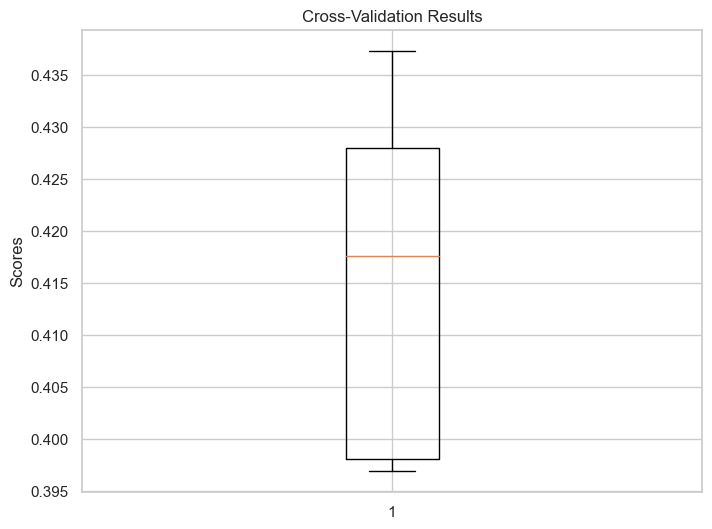

In [200]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.title("Cross-Validation Results")
plt.ylabel("Scores")
plt.boxplot(scores)
plt.show()

[[0.07234043 0.42340426 0.39574468 0.10851064]
 [0.06066536 0.41878669 0.43248532 0.08806262]
 [0.07809524 0.45904762 0.38095238 0.08190476]
 [0.08502024 0.4291498  0.39676113 0.08906883]]


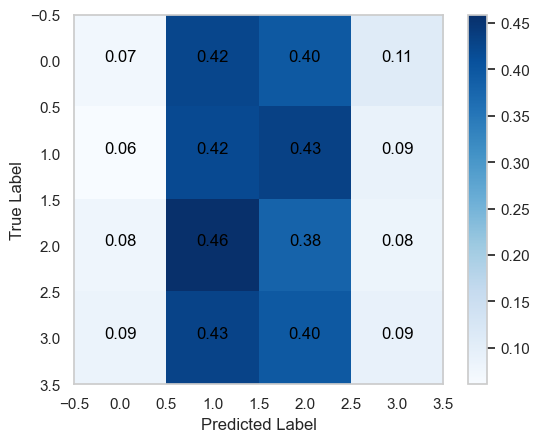

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import load_model

# if value in y_pred_test is greater than 4, set it to 4
y_pred_test[y_pred_test > 4] = 4
# if value in y_pred_test is less than or equal to 1, set it to 1
y_pred_test[y_pred_test <= 1] = 1

# Create a confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test.round(),normalize='true')
print(cm)

        
        
# Plot the confusion matrix
plt.imshow(cm,cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add numbers to the plot
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")
        
plt.show()

The results demonstrate that in its current state, the model appears to have at least some prediction capabilities. Predictions for severity 1 and 4 crashes appear to be no better than random, while the predictions for 2 and 3 are more accurate. However, it is interesting to note that severity 1 crashes are almost never labeled as severity 4, and vice versa. This means that the general range of the severity of a crash is captured decently, but the results are not precise enough. Perhaps the patterns are not linear and thus are not captured well with a basic linear regression. We continue to try to optimize the model in the next steps.

## 3.2. Feature Engineering

In an attempt to foster a stronger correlation between the input
features and their outputs, we created the following set of feature
mappings that attempt to capture more meaningful patterns in the input:

1.  Feature Mappings

    1.  *Amount of Light*: Derived from *Start Time*; A heuristic for
        the level of light present during the accident, based on the
        hour of the day.

    2.  *Day Number*: Derived from Start Time; The day in the year the
        accident occurred (with 0 representing January 1st and 364
        representing December 31st)

    3.  *Day of the Week*: Derived from Start Time; A one-hot encoding
        representing the day of the week the accident happened

    4.  *Duration* (s): Derived from Start Time and End Time; The
        duration of the accident

    5.  *Hour* (one-hot encoded): Derived from *Start Time*; What hour
        the accident occurred in during the day

    6.  *Seconds Since Start of Day*: Derived from *Start Time*; Number
        of seconds since 12:00 AM on the day of the accident

    7.  *Wind Vector X-component* (mi/hr): Derived from *Wind Direction*
        and *Wind Speed*; The x-component of the wind's vector at the
        time of the accident

    8.  *Wind Vector Y-component* (mi/hr): Derived from *Wind Direction*
        and *Wind Speed*; The y-component of the wind's vector at the
        time of the accident

        
Using these new feature mappings in addition to the original set of
data, we performed 5-fold cross validation again and noted the following
cross validation scores:

In [202]:
# Start with a basic linear model (the features are only standardized and are used as they are
# without any transformations) regardless if you are doing the least-squares data fitting (Chapter
# 13) or the least-squares classification (Chapter 14) task. Evaluate the initial model using cross-
# validation and report the RMS error. Make sure to save the model parameters for each fold of
# the cross-validation.

# specifically, here we want to use all the other features to predict severity of the crash (col 1), then use 5 fold cross validation to see how well it does


X = datanp_normalized[:,1:]
y = datanp_normalized[:,0]

data = np.column_stack((X, y))

# Shuffle the data
np.random.shuffle(data)

# Split the shuffled data into X and y arrays again
X = data[:, :-1]
y = data[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = Ridge(alpha=0.000000001)
regressor.fit(X_train, y_train)

# predict using the training and testing data to get scores
y_pred_train = regressor.predict(X_train).round()
y_pred_test = regressor.predict(X_test).round()

train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

# # print the R^2 scores
# print("Training set R^2 score: {:.2f}".format(train_score))
# print("Testing set R^2 score: {:.2f}".format(test_score))

# print the cross-validation scores
scores = cross_val_score(regressor, X, y, cv=5, scoring='r2')
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))


Cross-validation scores: [0.41484841 0.39643029 0.39996557 0.44006669 0.4137974 ]
Average cross-validation score: 0.41


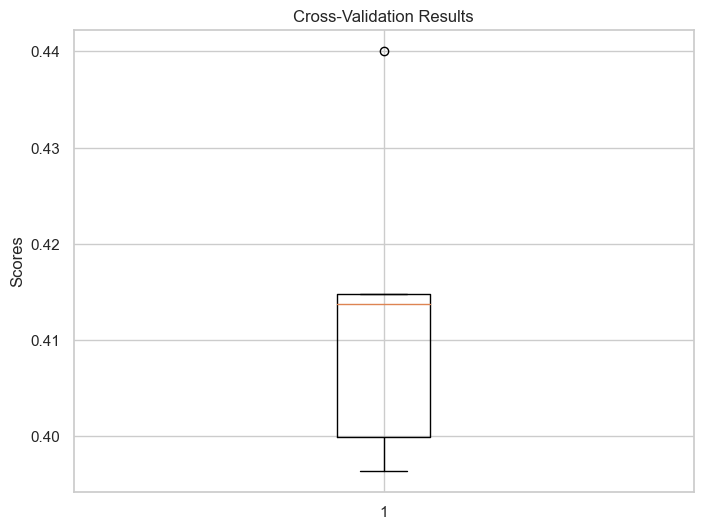

In [203]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.title("Cross-Validation Results")
plt.ylabel("Scores")
plt.boxplot(scores)
plt.show()

[[0.31311155 0.60665362 0.08023483 0.        ]
 [0.02083333 0.64204545 0.3219697  0.01515152]
 [0.00210084 0.22268908 0.62394958 0.1512605 ]
 [0.00412371 0.20824742 0.54639175 0.24123711]]


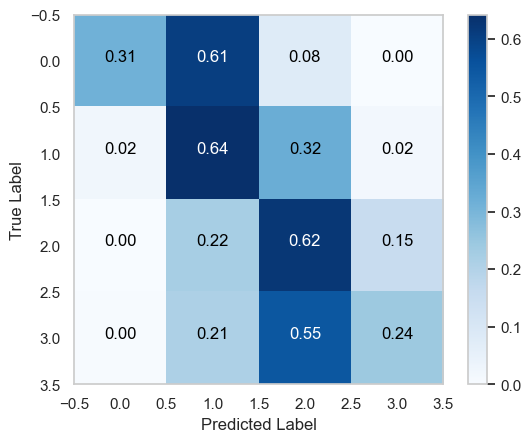

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import load_model

# if value in y_pred_test is greater than 4, set it to 4
y_pred_test[y_pred_test > 4] = 4
# if value in y_pred_test is less than or equal to 1, set it to 1
y_pred_test[y_pred_test <= 1] = 1

# Create a confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test.round(),normalize='true')
print(cm)

        
        
# Plot the confusion matrix
plt.imshow(cm,cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add numbers to the plot
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")
        
plt.show()

It appears that even with these new features, the confusion matrix does not seem to be much different from before. It is also possible that the feature mappings devised were simply not effective at capturing new patterns in the data. We now attempt to include regularization as an objective to see if it makes a difference.

## 3.3. Regularization

We now attempt to train the model with L2 regularization, which should prevent the model from learning weights that too strongly impact some features over others. We arbitrarily split the data into a training and test set (80-20 split) and attempt to find the hyperparameter $\lambda$ that best balances the objective of fitting the linear model and regularization. To do this, we iterated through all values of $\lambda$ from 0 to 100 at increments of 0.01 and performed 5-fold cross validation on the data at each iteration, recording the average cross validation score at each iteration. Below is a plot of the average cross validation score versus the hyperparameter:

Best hyperparameter: 4.21
Best Cross-validation scores: [0.42745708 0.40211241 0.4131195  0.42119515 0.414004  ]
Best Average cross-validation score: 0.42


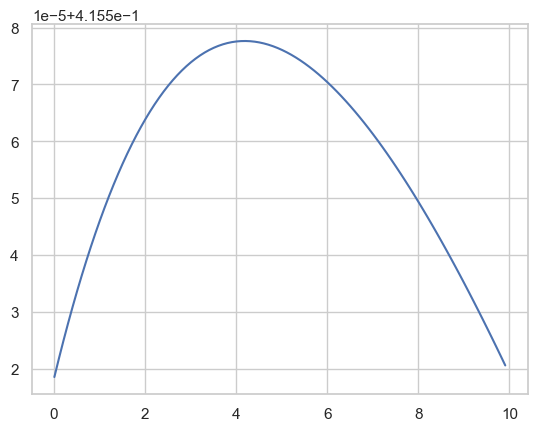

In [205]:
# PART 3C:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from numpy import mean
from sys import float_info

X = datanp_normalized[:,1:]
y = datanp_normalized[:,0]

best_hyper = 0
best_score = float_info.min
hypers = 0.1 * np.arange(0, 100) +0.01
avg_scores = []
# Linear Regression with Regularization (test different hyperparameters)
for hyper in hypers:

    # Initialize the regressor with the hyperparameter
    regressor = Ridge(alpha=hyper)

    # Score this specific hyper parameter's performance
    scores = cross_val_score(regressor, X, y, cv=5, scoring='r2')

    score = scores.mean()
    
    avg_scores.append(score)

    if(score > best_score):
        best_score = score
        best_hyper = hyper

# Plot the avg cross validation score vs hyper parameter
plt.plot(hypers, avg_scores)

# Use the highest performing hyper parameter
best_regressor = Ridge(alpha=best_hyper)

best_regressor.fit(X_train, y_train)

scores = cross_val_score(best_regressor, X, y, cv=5, scoring='r2')

print("Best hyperparameter: {:.2f}".format(best_hyper))
print("Best Cross-validation scores: {}".format(scores))
print("Best Average cross-validation score: {:.2f}".format(scores.mean()))

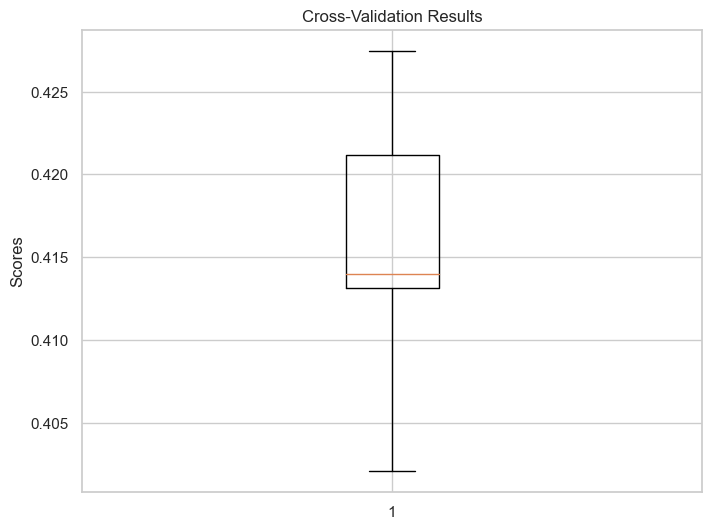

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.title("Cross-Validation Results")
plt.ylabel("Scores")
plt.boxplot(scores)
plt.show()

[[0.3072407  0.61252446 0.08023483 0.        ]
 [0.01704545 0.65151515 0.31628788 0.01515152]
 [0.00210084 0.21428571 0.6302521  0.15336134]
 [0.00412371 0.20824742 0.5443299  0.24329897]]


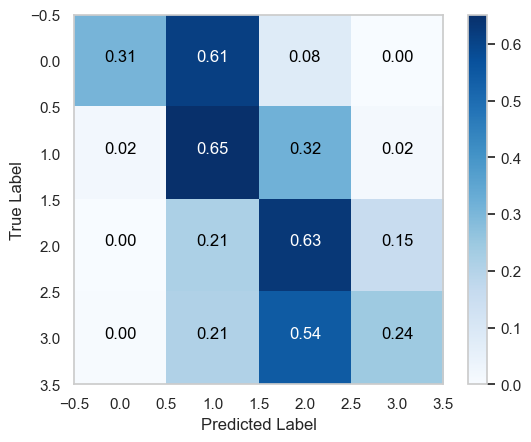

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import load_model

y_pred_test = best_regressor.predict(X_test).round()


# if value in y_pred_test is greater than 4, set it to 4
y_pred_test[y_pred_test > 4] = 4
# if value in y_pred_test is less than or equal to 1, set it to 1
y_pred_test[y_pred_test <= 1] = 1

# Create a confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test,normalize='true')
print(cm)

        
        
# Plot the confusion matrix
plt.imshow(cm,cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add numbers to the plot
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")
        
plt.show()

It appears adding regularization did not impact the accuracy of the model that much, besides a slight increase in accuracy for predicting severity 1 accidents. Perhaps linearity of the patterns is an issue.

## 3.4 Non-linear Models

Finally, we will attempt to use non-linear models to see whether the
linearity of the model was a significant factor that contributed to its
poor prediction capabilities.\

We will first try to use Logistic Regression with class weights instead of Linear Regression to see if we can get better results.

In [208]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

X = datanp_normalized[:,1:]
y = datanp_normalized[:,0]

# Shuffle the data
data = np.column_stack((X, y))
np.random.shuffle(data)

# Split the shuffled data into X and y arrays again
X = data[:, :-1]
y = data[:, -1]

# Define the K-Fold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Initialize an array to store the model parameters
intercept_list = []
coeff_list = []

scores = []

# Loop through the folds
fold = 0
for train_index, test_index in kf.split(X):
    
    # Split the data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model on the training set
    regressor = LogisticRegression(max_iter=1000)
    regressor.fit(X_train, y_train)
    
    # Save the model parameters
    intercept_list.append(regressor.intercept_)
    coeff_list.append(regressor.coef_)

    # Evaluate the model on the testing set
    accuracy = regressor.score(X_test, y_test)
    scores.append(accuracy)
    # print("Fold {} accuracy: {:.2f}".format(fold, accuracy))
    
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(np.mean(scores)))



Cross-validation scores: [0.64, 0.674, 0.6705, 0.661, 0.668]
Average cross-validation score: 0.66


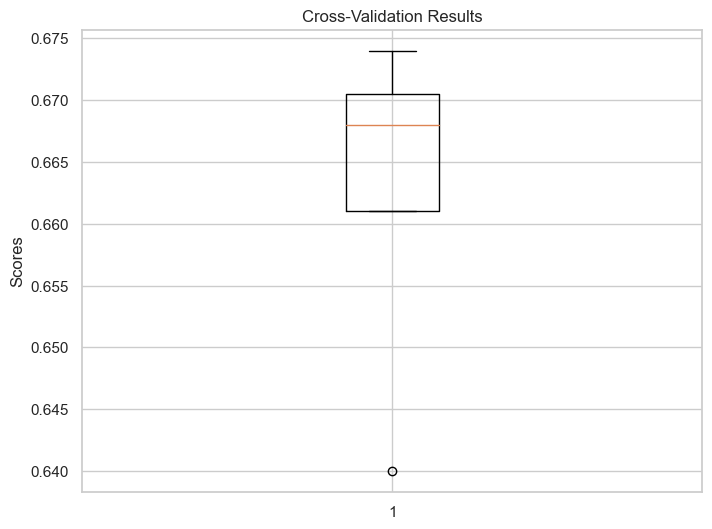

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.title("Cross-Validation Results")
plt.ylabel("Scores")
plt.boxplot(scores)
plt.show()

[[0.89046653 0.03853955 0.03042596 0.04056795]
 [0.12076271 0.65677966 0.10805085 0.11440678]
 [0.0994575  0.08137432 0.57504521 0.24412297]
 [0.08713693 0.1846473  0.17842324 0.54979253]]


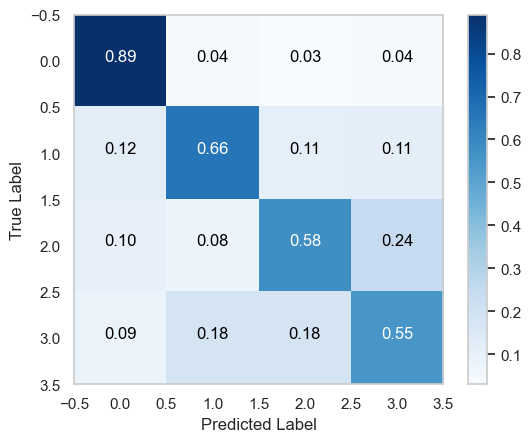

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import load_model



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
regressor = LogisticRegression(max_iter=1000)
regressor.fit(X_train, y_train)
y_pred_train = regressor.predict(X_train).round()
y_pred_test = regressor.predict(X_test).round()


# if value in y_pred_test is greater than 4, set it to 4
y_pred_test[y_pred_test > 4] = 4
# if value in y_pred_test is less than or equal to 1, set it to 1
y_pred_test[y_pred_test <= 1] = 1


# Create a confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test,normalize='true')
print(cm)

        
        
# Plot the confusion matrix
plt.imshow(cm,cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add numbers to the plot
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")
        
plt.show()

Lastly, we will attempt to use a neural network to predict the severity.

The model is a sequential neural network built using Keras API with four dense layers with ReLU activation function and a final dense layer with softmax activation function. The input layer takes a vector of length 165 (i.e., 165 features).

The first dense layer has 32 neurons and uses L2 regularization with a parameter of 0.01. It is followed by a dropout layer that randomly sets 10% of the input units to 0 during training to prevent overfitting.

The second dense layer has 16 neurons with L2 regularization with a parameter of 0.01 and is followed by a dropout layer with the same configuration.

The third dense layer has 8 neurons with L2 regularization with a parameter of 0.01 and is followed by a dropout layer with the same configuration.

The last dense layer has 4 neurons (i.e., number of classes) with softmax activation function. The model is compiled with Adam optimizer, categorical_crossentropy loss function, and accuracy metrics for evaluation.

The model is trained using 5-fold cross-validation with 25 epochs, a batch size of 32, and shuffle. Finally, the model is trained on the full training set and evaluated on the test set.

In [211]:
# use keras to train on this instead...

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from keras.utils import to_categorical
from keras import regularizers
from sklearn.model_selection import KFold


# load and preprocess the data

X = datanp_normalized[:, 1:]
y = datanp_normalized[:, 0]

y = y-1

y_one_hot = to_categorical(y, num_classes=4)  # One-hot encode y with 4 categories


X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)


model = keras.Sequential([
    # keras.layers.Reshape((11, 15, 1)),  # Reshape to 2D image
    # keras.layers.Conv2D(16, (3, 3), activation='relu'),
    # keras.layers.MaxPooling2D((2, 2)),  # Add pooling layer
    keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(8 , activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.1),
    # keras.layers.Flatten(),
    keras.layers.Dense(4, activation='softmax')
])
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae'])


k = 5  # Number of folds for cross-validation
num_epochs = 25  # Number of epochs to train the model
batch_size = 32  # Batch size for training the model


# Initialize a KFold object for k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)
# Initialize arrays to store the model parameters for each fold
weights_list = []
biases_list = []

# Iterate over the folds and train the model on each fold
scores = []
for train_indices, val_indices in kf.split(X_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_indices], y_train[train_indices]
    X_val_fold, y_val_fold = X_train[val_indices], y_train[val_indices]
    
    # Train the model on the training data for this fold
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_fold, y_val_fold))
    
    # Save the model parameters
    weights = model.get_weights()
    weights_list.append(weights[0])
    biases_list.append(weights[1])
    
    # Evaluate the model on the validation data for this fold and store the result
    scores.append(model.evaluate(X_val_fold, y_val_fold, verbose=0)[1])
    
print("Best Cross-validation scores: {}".format(scores))
print("Best Average cross-validation score: {:.2f}".format(np.mean(scores)))
 
    
# train the model

model_single = keras.Sequential([
    # keras.layers.Reshape((11, 15, 1)),  # Reshape to 2D image
    # keras.layers.Conv2D(16, (3, 3), activation='relu'),
    # keras.layers.MaxPooling2D((2, 2)),  # Add pooling layer
    keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(8 , activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.1),
    # keras.layers.Flatten(),
    keras.layers.Dense(4, activation='softmax')
])
# compile the model

model_single.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae'])
history_single = model_single.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), verbose = 0)

# evaluate the model on the test set
# evaluate the model on the test set
loss, mae = model_single.evaluate(X_test, y_test)
mse = mean_squared_error(y_test.argmax(axis=1), model_single.predict(X_test).argmax(axis=1))  # Convert one-hot encoded output to non-encoded


print("Test loss: {:.4f}".format(loss))
print("Test MSE: {:.4f}".format(mse))






Best Cross-validation scores: [0.6856250166893005, 0.7087500095367432, 0.7112500071525574, 0.7024999856948853, 0.7068750262260437]
Best Average cross-validation score: 0.70
63/63 [==============================] - 0s 538us/step
Test loss: 0.8965
Test MSE: 0.8180


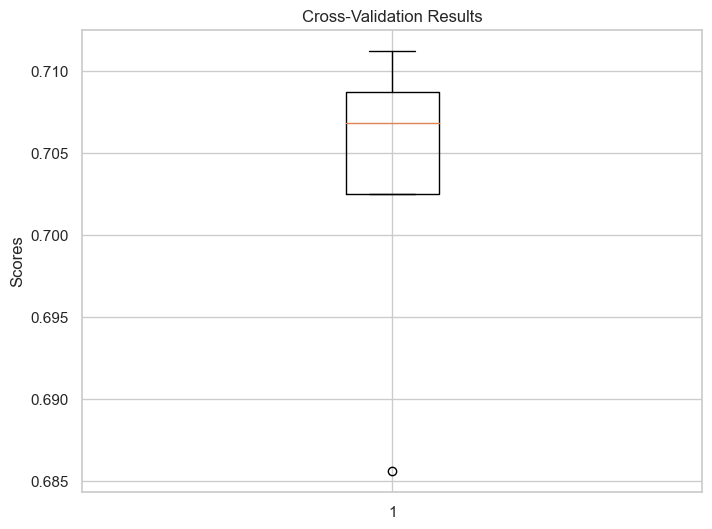

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.title("Cross-Validation Results")
plt.ylabel("Scores")
plt.boxplot(scores)
plt.show()

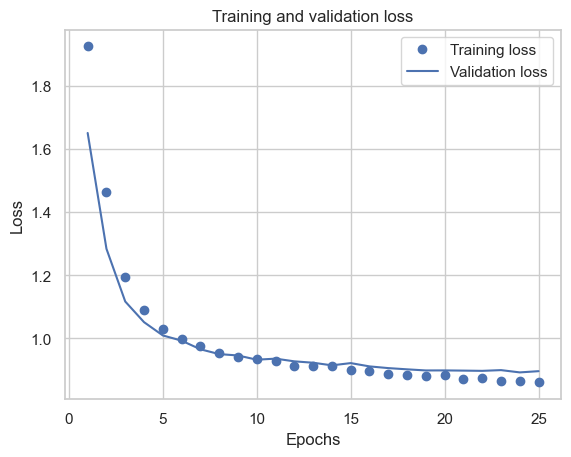

In [213]:

# plot the training and validation loss over epochs
train_loss = history_single.history['loss']
val_loss = history_single.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [214]:
y_pred_round = model.predict(X_test).argmax(axis=1).round()

# if value in y_pred_test is greater than 4, set it to 4
y_pred_test[y_pred_test > 4] = 4
# if value in y_pred_test is less than or equal to 1, set it to 1
y_pred_test[y_pred_test <= 1] = 1

# compare the actual and predicted values to get an accuracy score
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test.argmax(axis=1), y_pred_round))


63/63 [==============================] - 0s 561us/step
0.6905


[[0.92629482 0.00996016 0.03984064 0.02390438]
 [0.04708098 0.68926554 0.12241055 0.14124294]
 [0.12298387 0.06048387 0.56653226 0.25      ]
 [0.05732484 0.18046709 0.1910828  0.57112527]]


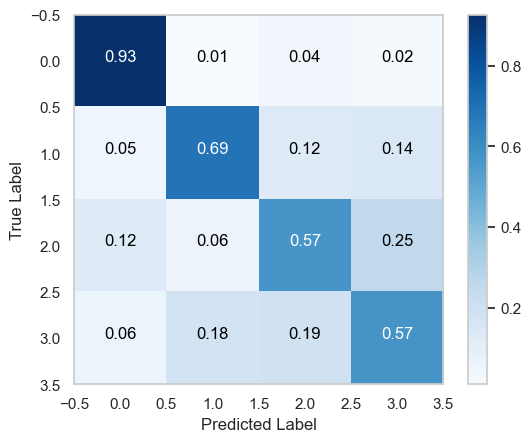

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import load_model


# if value in y_pred_test is greater than 4, set it to 4
y_pred_test[y_pred_test > 4] = 4
# if value in y_pred_test is less than or equal to 1, set it to 1
y_pred_test[y_pred_test <= 1] = 1


# Create a confusion matrix
cm = confusion_matrix(y_true=y_test.argmax(axis=1), y_pred=y_pred_round,normalize='true')
print(cm)

        
        
# Plot the confusion matrix
plt.imshow(cm,cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add numbers to the plot
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")
        
plt.show()

Incredibly, it appears that both of these non-linear models demonstrate a significantly higher capacity for predicting the severity of a crash. Now, severity 1 accidents are the best predicted with an accuracy of around 90\%. While severity 4 accidents are still not well predicted at around 50\%, it still demonstrates a great improvement over the linear models. An interesting trend is that the prediction for the severity of a crash tends to become less precise as it increases. One hypothesis for why this might happen is that it becomes more and more difficult for humans (including those who scored the severity of the crashes in the data set) to distinguish the difference between higher severity crashes.

# 4 Complexity Analysis

This section 4 and the conclusion are due March 24, 2023 at 11:59pm.

## 4.1 Number of Flops

\
**Part 3.1**\
To train a linear regression model, the following linear equation needs
to be solved:

$$A\theta = b$$

If we let $n$ be the number of input data points and $p$ be the number
of features, then $A$ is a $n$ x $p$ matrix representing the input data
points, $\theta$ is a $p$-vector representing the model (as a vector of
weights for each feature), and $b$ is a $n$-vector representing the true
labels for each input data point.\
Thus, the model $\theta$ can be trained by evaluating

$$(A^TA)^{-1}A^Tb$$

The complexity of evaluating $(A^TA)$ is $O(n^2p)$ since it is the
multiplication of a $p$ x $n$ and a $n$ x $p$ matrix. Inverting this $p$
x $p$ gram matrix is then $O(p^3)$. The complexity of multiplying the
$p$ x $p$ gram matrix by the $p$ x $n$ $A^T$ matrix and $n$-vector $b$
is $O(p^2n)$. Thus, the time complexity for the computation is
$O(n^2p) + O(p^3) + O(p^2n)$. However, because $n \gg p$, we can put the
complexity for training the model at $O(n^2p) + O(p^3)$.\
Since prediction is simply evaluating

$$A\theta,$$

which is a $n$ x $p$ matrix multiplied by a $p$-vector. Thus, the time
complexity for prediction is $O(np)$.\
The next phase in this portion is the validation, which was performed
using 5-fold cross validation with 80% of the data used for training and
20% of the data used for testing. Each fold thus has complexity

$$0.8\cdot O(n^2p + p^3) + 0.2\cdot O(np)$$

It follows that the 5-fold cross validation has complexity

$$5 \cdot (0.8\cdot O(n^2p + p^3) + 0.2\cdot O(np))$$

In conclusion,

1.  Training: $O(n^2p) + O(p^3)$

2.  Prediction: $O(np)$

3.  Validation: $5 \cdot (0.8\cdot O(n^2p + p^3) + 0.2\cdot O(np))$

For this model, $p \approx 160$. The prediction for an individual data
point is approximately $p$ and will take approximately 160 flops. The
RMS for this model was 0.42. Thus, the ratio of RMS units to flops on
prediction is approximately 0.0026.

**Part 3.2**\
Since this portion involves the exact same computations except using the
8 new engineered features in addition to the original set of features.
Thus we have the following complexities:

1.  Training: $O(n^2p_1) + O(p_1^3)$

2.  Prediction: $O(np_1)$

3.  Validation:
    $5 \cdot (0.8\cdot O(n^2p_1 + p_1^3) + 0.2\cdot O(np_1))$

where $p_1$ represents the number of total features, including
engineered features. However, from this point on, we shall assume that
$p$ accounts for the engineered features.\
For this model, $p_1 \approx 165$. The prediction for an individual data
point is approximately $p$ and will take approximately 165 flops. The
RMS for this model was 0.41. Thus, the ratio of RMS units to flops on
prediction is approximately 0.0025.

**Part 3.3**\
In class, we learned that solving a least squares problem with
regularization is equivalent to solving the least squares problem

$$\mathrm{minimize} \quad
\left\lVert 
\begin{bmatrix} 
    A_1 \\
    \sqrt{\lambda} A_2
\end{bmatrix} \theta
-
\begin{bmatrix}
    y \\
    0
\end{bmatrix}
\right\rVert^2$$

where $A_1$ is a $n$ x $p$ matrix representing the input data, $A_2$ is
a $p$ x $p$ identity matrix, $\lambda$ is the hyperparameter, and $y$ is
a $n$-vector representing the labels for all of the input data.\
Following from the computations in **Part 3.1**, the time complexities
are as follows:

1.  Training: $O((n + p)^2p) + O(p^3)$

2.  Prediction: $O((n + p)p)$

3.  Validation:
    $5 \cdot (0.8\cdot O((n + p)^2p + p^3) + 0.2\cdot O((n + p)p))$

\
For this model, $p \approx 165$ and $n \approx 2000$. The prediction for
an individual data point takes approximately
$\frac{(n + p)p}{n} \approx 180$ flops. The RMS for this model was 0.42.
Thus, the ratio of RMS units to flops on prediction is approximately
0.0023.

**Part 3.4**\
Since a logistic regression is the same as a linear regression but with
the prediction being run through a sigmoid function, the complexities
for the logistic regression are the same as in **Part 3.1**:

1.  Training: $O(n^2p) + O(p^3)$

2.  Prediction: $O(np)$

3.  Validation: $5 \cdot (0.8\cdot O(n^2p + p^3) + 0.2\cdot O(np))$

For this model, $p \approx 165$. The prediction for an individual data
point is approximately $p$ and will take around 165 flops. The RMS for
this model was 0.66. Thus, the ratio of RMS units to flops on prediction
is approximately 0.004.\
The neural network, however, is more complex and requires more detailed
analysis. The discussion linked
[here](https://ai.stackexchange.com/questions/5728/what-is-the-time-complexity-for-training-a-neural-network-using-back-propagation)
provides insight into how the training complexity might be computed.
Based on the discussion, the time complexity for training would be
$O(nt(pi + ij + jk + kl)$, where $n$ is the number of data points, $t$
is the number of epochs, $p$ is the number of features, $i$ is the
number of nodes in the first layer, $j$ in the second layer, $k$ in the
third, and $l$ in the fourth. Since prediction involves propagating $n$
data points with $p$ features to compute $i$ nodes in the first layer,
each of which are used to compute $j$ nodes in the second layer, $k$ in
the third, and $l$ in the fourth, we estimate the time complexity for
prediction is $O(n(pi + ij + jk + kl)$.\
In conclusion we have:

1.  Training: $O(nt(pi + ij + jk + kl)$

2.  Prediction: $O(n(pi + ij + jk + kl)$

For this model, $p \approx 165$, $i = 32$, $j = 16$, $k = 8$, and
$l = 4$. The prediction for an individual data point takes approximately
$(pi + ij + jk + kl) \approx (5280 + 512 + 128 + 32) \approx 6000$
flops. The RMS for this model was 0.71. Thus, the ratio of RMS units to
flops on prediction is approximately 0.0001.


# 4.2 Stability
Now, we will analyze the stability of the models, so that we can understand how robust the models are to changes in the input data or other factors. We will analyze the stability of the two best models amonst those in part 3a, b, c, and d. These are the logistic model, which is very similar to a linear model, and the neural network.

In [216]:
np.set_printoptions(suppress=True)

# Compute the mean and standard deviation of each parameter across the folds
mean_weights = np.mean(weights_list, axis=0)
std_weights = np.std(weights_list, axis=0)
mean_biases = np.mean(biases_list, axis=0)
std_biases = np.std(biases_list, axis=0)

# Examine if those parameters are close to one another
print("Mean weights across folds:\n", mean_weights)
print("Standard deviation of weights across folds:\n", std_weights)
print("Mean biases across folds:\n", mean_biases)
print("Standard deviation of biases across folds:\n", std_biases)

# Compute the norm of the model parameters and comment on the value
norm_weights = np.linalg.norm(mean_weights)
norm_biases = np.linalg.norm(mean_biases)
print("Norm of weights:", norm_weights)
print("Norm of biases:", norm_biases)

mean_mean_weights = np.mean(np.abs(mean_weights))
mean_mean_biases = np.mean(np.abs(mean_biases))
print("Mean mean of weights across folds:", mean_mean_weights)
print("Mean mean of biases across folds:", mean_mean_biases)

mean_std_weights = np.mean(std_weights)
mean_std_biases = np.mean(std_biases)
print("Mean standard deviation of weights across folds:", mean_std_weights)
print("Mean standard deviation of biases across folds:", mean_std_biases)

Mean weights across folds:
 [[-0.09416533 -0.08822675 -0.04867517 ... -0.11838212  0.79660016
   0.15304127]
 [ 0.03490327 -0.01414941  0.08410834 ...  0.06965595  0.02322438
   0.00531746]
 [ 0.01325057  0.01236455 -0.00605371 ...  0.02996645 -0.00720573
  -0.01933223]
 ...
 [-0.00528619 -0.00895192 -0.03085895 ...  0.0124515   0.00235737
   0.07163746]
 [-0.02902167  0.03886713 -0.02068016 ... -0.04907054  0.00277658
  -0.03312748]
 [-0.01595694  0.01436862  0.04672033 ... -0.05032126  0.0084302
   0.00014604]]
Standard deviation of weights across folds:
 [[0.02464142 0.04220967 0.01998397 ... 0.02659722 0.01647231 0.03520989]
 [0.01988797 0.03240931 0.03649561 ... 0.00799549 0.01429414 0.03035581]
 [0.01005861 0.02097583 0.01494787 ... 0.01410805 0.00123363 0.00399172]
 ...
 [0.02624385 0.01841485 0.00696598 ... 0.02244538 0.00404211 0.0098933 ]
 [0.01777479 0.02169065 0.00926022 ... 0.02803901 0.00717938 0.01398094]
 [0.01224775 0.03053804 0.020615   ... 0.00969467 0.00681846 0.016

Looking at the results for the logistic model, it seems that the biases are quite numerically stable, as the mean mean of the biases is quite a bit higher than the mean stadard deviation of the biases. However the same cannot be said for the weights - the mean mean of the weights and the mean standard deviation of the weights is comparable, indicating that the weights are not very stable. This suggests that we may not want to rely on this model, as it varies wildly with the input data.

In [217]:
# Compute the mean and standard deviation of each parameter across the folds

mean_weights = np.mean(coeff_list, axis=0)
std_weights = np.std(coeff_list, axis=0)
mean_biases = np.mean(intercept_list, axis=0)
std_biases = np.std(intercept_list, axis=0)

# Examine if those parameters are close to one another
print("Mean weights across folds:\n", mean_weights)
print("Standard deviation of weights across folds:\n", std_weights)
print("Mean biases across folds:\n", mean_biases)
print("Standard deviation of biases across folds:\n", std_biases)

# Compute the norm of the model parameters and comment on the value
norm_weights = np.linalg.norm(mean_weights)
norm_biases = np.linalg.norm(mean_biases)
print("Norm of weights:", norm_weights)
print("Norm of biases:", norm_biases)


mean_mean_weights = np.mean(np.abs(mean_weights))
mean_mean_biases = np.mean(np.abs(mean_biases))
print("Mean mean of weights across folds:", mean_mean_weights)
print("Mean mean of biases across folds:", mean_mean_biases)

mean_std_weights = np.mean(std_weights)
mean_std_biases = np.mean(std_biases)
print("Mean standard deviation of weights across folds:", mean_std_weights)
print("Mean standard deviation of biases across folds:", mean_std_biases)

Mean weights across folds:
 [[ 0.34035347 -1.07573338  0.51917123 -5.85370579  1.89729551 -2.63504671
  -0.70047111  0.00301101 -0.66106311  1.31481349  0.05648932 -0.16751533
  -0.03131962  0.06010053  0.03096202  0.01930626  0.12329182 -0.01717257
   0.03025701  0.09681836  0.0443385   0.04533769  0.00365634 -0.00822068
   0.         -0.01799265  0.01558467  0.04275951  0.32974628  0.
   0.29481693  0.08789538  0.00539432  0.41195064 -1.04004295  0.37417597
   0.08016392  0.14606576  0.43878229  0.03148419  0.10406301  0.
  -0.04831925 -0.0008227   0.03651291 -0.01457256 -0.07109348  0.0444745
   0.         -0.00170315  0.00233561 -0.00108883 -0.00500263 -0.00964291
   0.24662399 -0.00393302  0.05030368  0.09596016  0.06543391 -0.04195242
  -0.04811393  0.3188063   0.03557469 -0.02189226 -0.84384672  0.28613072
   0.09105417  0.04891837  0.12539774  0.03332712 -0.58470567 -0.02470005
   0.04368705 -0.15581503  0.09996426  0.00013948  0.07091833  0.
   0.0058057   0.00544799 -0.062342

Now we analyze the numerical stability for the neural network. We can see unlike the logistic model, quite surprisingly, the weights and biases acutally seem more stable. The mean mean of the weights is quite a bit larger than the mean standard deviation and same holds for the biases. This is likely due to the fact that the neural network is a non-linear model, and thus the weights and biases are not as sensitive to the data. This is good news for our model, as it means that the weights and biases are not changing drastically from fold to fold, and thus the model is more stable. Given these results, we can be confident in using this model for the prediction.

# 5. Conclusion

We analyzed a data set of around 2.9 million data points describing traffic accidents that occurred in the United States between 2016 and 2021 and attempted to build models that can predict the severity of an accident (on a scale from 1 to 4) based on its features. After cleaning up the data, we analyzed the input features and discovered relatively low correlation between any feature and severity. This is evidence that the problem of predicting severity based on the input features provided is not trivial. From here, we attempted to predict severity by training a basic linear regression model. The results demonstrated that the model was able to capture the relative severity of an accident but did not have a precise read on the specific severity label. Engineering additional features based on the original set of features and adding a regularization objective to the training of the linear regression model did not appear to impact the results significantly. However, logistic regression and neural network models demonstrated a great improvement in performance, with both models correctly predicting severity 1 accidents with around 90% accuracy, severity 2 and 3 with around 70% accuracy, and severity 4 accidents with around 50% accuracy. These results demonstrate that the patterns inherent in the input data are likely to be non-linear. Perhaps with the addition of more input features and data points, this model could be improved even further.
